<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/2B_ML_workflow_class_balanced_average_precision_player_plus_team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# remove library not used
import pandas as pd
import numpy as np
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from matplotlib.pyplot import figure
import copy
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, average_precision_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# packages for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# packages for loading and dumping models
from google.colab import drive, files
import os
from joblib import dump, load

# packages for ensemble learning
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

In [2]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# Read train set

In [3]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_train_comprehensive_playerplusteam.pkl?raw=true")
train_set

,PLAYER_ID_P,PLAYER_NAME_P,NICKNAME_P,TEAM_ABBREVIATION_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,CFPARAMS_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,TEAM_NAME_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,CFPARAMS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,82,Bill Wennington,Bill,CHI,34.0,47,41,6,0.872,51.8,7.5,15.5,0.483,0.0,0.2,0.000,2.3,2.8,0.811,3.0,5.4,8.4,2.8,2.4,0.8,0.8,0.6,8.6,0.0,17.3,7.2,1,0,5,"82,1610612741",0.079,12.5,1.16,99.5,0.105,0.483,4.3,2.1,8.3,107.7,0.058,93.11,77.59,0.049,1308,0.082,10.8,0.515,0.163,14.4,12.8,15.5,43.0,3.8,0.9,2.3,4.0,0.888,0.000,0.888,0.990,0.010,0.867,0.637,0.000,0.053,0.133,0.133,0.230,0.112,0.000,0.112,0.196,0.169,0.093,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1610612741.0,1,1996-97,1610612741199697
1,679,Jason Caffey,Jason,CHI,24.0,41,35,6,0.854,51.9,8.2,14.7,0.556,0.0,0.0,0.000,4.7,7.7,0.606,4.2,5.6,9.8,3.1,4.3,0.9,0.2,1.9,6.6,0.0,21.0,5.3,0,0,5,"679,1610612741",0.093,12.1,0.71,99.8,0.107,0.556,4.3,2.4,7.2,107.0,0.087,93.43,77.86,0.073,1213,0.097,16.9,0.581,0.191,16.7,10.6,16.3,40.7,3.8,3.3,5.0,12.0,0.677,0.000,0.677,1.000,0.000,0.776,0.204,0.000,0.157,0.224,0.239,0.573,0.323,0.000,0.323,0.070,0.187,0.095,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1610612741.0,1,1996-97,1610612741199697
2,893,Michael Jordan,Michael,CHI,34.0,48,42,6,0.875,52.4,16.0,32.7,0.489,1.8,5.1,0.347,8.8,10.3,0.852,1.9,6.0,7.8,5.4,2.3,2.3,0.7,0.9,2.5,0.0,42.6,14.9,3,0,5,"893,1610612741",0.191

# Exploratory data analysis
- dataset set can be split into left and right half
- features = team stats
- Y = PLAYOFF_RANKING

In [4]:
pd.DataFrame(train_set.dtypes).T

,PLAYER_ID_P,PLAYER_NAME_P,NICKNAME_P,TEAM_ABBREVIATION_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,CFPARAMS_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,TEAM_NAME_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,CFPARAMS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,object,object,object,object,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,category,category,object


In [5]:
train_set.describe()

,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T
count,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000,5701.000000
mean,27.252412,44.797755,22.365901,22.431854,0.497531,50.187967,7.413384,16.470795,0.451707,1.482336,4.197404,0.268529,3.482477,4.662586,0.744528,2.400158,6.520172,8.921154,4.298281,2.832047,1.557955,1.055218,1.010033,4.660112,2.912577,19.790738,-0.455429,4.175759,0.115418,0.139075,16.099947,1.540296,1

In [6]:
# explanatory variable (Y) = PLAYOFF_RANKING
train_set.groupby(["SEASON"]).PLAYOFF_RANKING.value_counts().reset_index().pivot(index = "level_1", columns = "SEASON", values = "PLAYOFF_RANKING")

SEASON,1996-97,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22
level_1,,,,,,,,,,,,,,,,,,,,,,,,
0,224,215,220,240,218,227,246,213,228,231,210,208,248,139,224,234,284,276,251,227,255,260,149,266
1,10,11,0,11,11,0,12,9,11,0,12,11,11,7,11,13,10,12,13,0,0,13,8,12


In [7]:
# no missing data
train_set.isna().sum()[train_set.isna().sum() != 0]

Series([], dtype: int64)

In [8]:
numeric_col = train_set.select_dtypes(include=np.number).columns.values.tolist()
print(f"number of numeric columns: {len(numeric_col)}")

number of numeric columns: 164


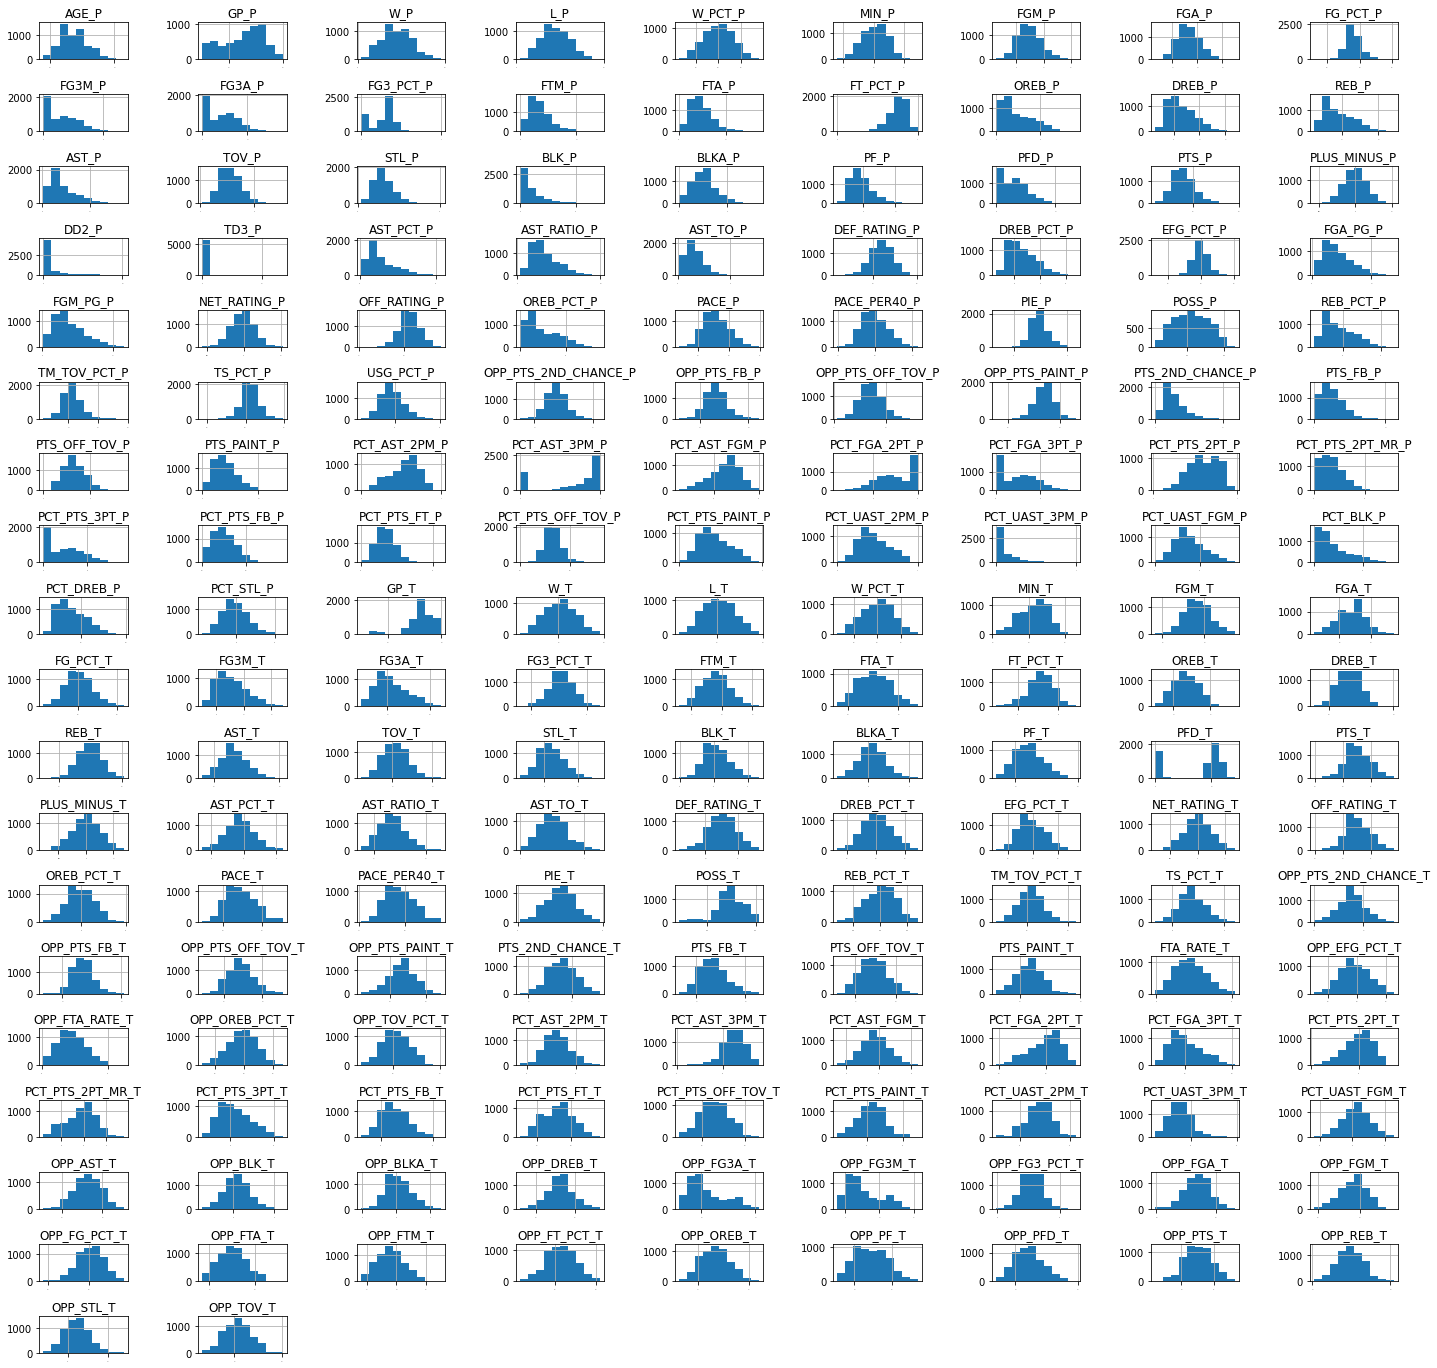

In [9]:
# plot distributions of each numeric column
train_set.hist(bins=10, layout = (20, int(len(numeric_col) / 20) + 1), figsize= (20,20), xlabelsize=0)
plt.tight_layout()
plt.show()

## Class imbalance in y

In [10]:
# only 3% of data in positive class (winning a championship)
train_set.PLAYOFF_RANKING.value_counts(normalize=True)*100

0    96.351517
1     3.648483
Name: PLAYOFF_RANKING, dtype: float64

## Outliers in PFD - to be fixed in num_pipeline

In [11]:
# equivalent measure: PFD_T (# of fouls drawn) = OPP_PF (# of fouls committed by opponent)
# outlier: PFD_T (Personal Fouls Drawn) with a high frequency at 0 
train_set.PFD_T.value_counts(bins = 10).sort_index()

(-0.029500000000000002, 2.85]    1579
(2.85, 5.7]                        66
(5.7, 8.55]                         0
(8.55, 11.4]                        0
(11.4, 14.25]                       0
(14.25, 17.1]                       0
(17.1, 19.95]                     907
(19.95, 22.8]                    2181
(22.8, 25.65]                     886
(25.65, 28.5]                      82
Name: PFD_T, dtype: int64

In [12]:
# while OPP_PF_T (ie PFD) has a more even distribution
# consider replacing PFD with OPP_PF_T
train_set.OPP_PF_T.value_counts(bins = 10).sort_index()

(17.688, 18.78]     229
(18.78, 19.86]      590
(19.86, 20.94]     1034
(20.94, 22.02]      949
(22.02, 23.1]       949
(23.1, 24.18]       819
(24.18, 25.26]      684
(25.26, 26.34]      288
(26.34, 27.42]      106
(27.42, 28.5]        53
Name: OPP_PF_T, dtype: int64

In [13]:
# bi-modal distribution: % of 3 points assisted becuz not everyone shoots 3
# while % of 2 points assisted is not bi-modal becuz everyone shoots 2 
# make sense, a lot of players don't shoot 3 (0%) and good shooters usually spot up (100%)
train_set.PCT_AST_3PM_P.value_counts(bins=10).sort_index()

(-0.002, 0.1]    1272
(0.1, 0.2]          5
(0.2, 0.3]         20
(0.3, 0.4]         40
(0.4, 0.5]        110
(0.5, 0.6]        174
(0.6, 0.7]        284
(0.7, 0.8]        500
(0.8, 0.9]        841
(0.9, 1.0]       2455
Name: PCT_AST_3PM_P, dtype: int64

## Correlation matrix

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


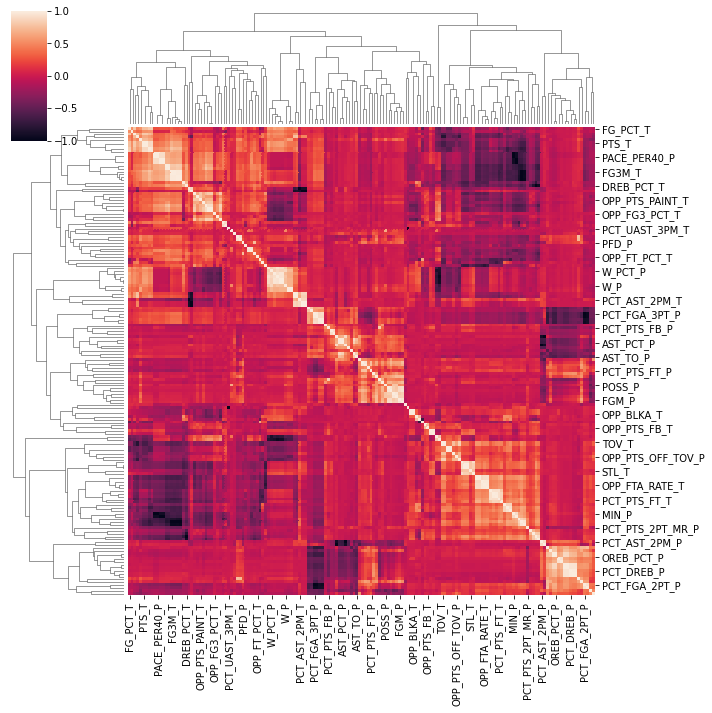

In [14]:
corr_mat = train_set.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(corr_mat, 
#             annot=False, 
#             vmin=-1,
#             vmax=1,
#             mask = np.triu(corr_mat)) # to show only lower triangle
# plt.show()

# use dendrogram to see clusters
# offense and defensive stats tend to cluster with each other
sns.clustermap(corr_mat)

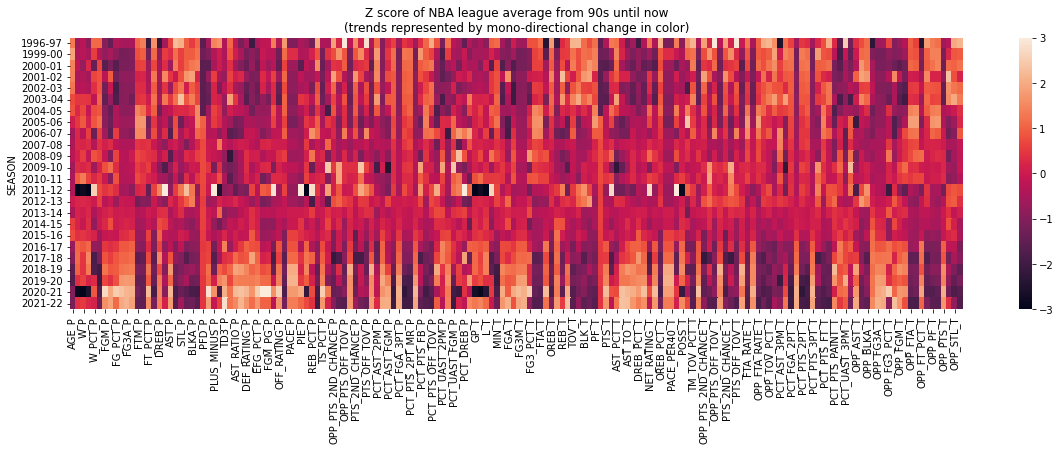

In [15]:
# it's often mentioned that NBA teams in different era play with different styles
# we have already adjusted the stats per possession so pace doesn't impact the numbers here
# in 90s, teams tend to focus more on defense and are more physical (higher PF, BLK, STL, TOV)
# in recent era, teams shoot more 3s and score more points (FG and FG3)
# Feature engineering: clustering for SEASON to take into account this difference 
ax = sns.heatmap(train_set.loc[:,numeric_col + ["SEASON"]].groupby("SEASON").mean().apply(zscore),
                 vmin=-3, vmax=3)
plt.title("Z score of NBA league average from 90s until now\n(trends represented by mono-directional change in color)")
# for col in [
#     ("FGA"), ("FG3A"), ("TOV", "STL", "BLK", "BLKA", "PF"),
#     ('OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT'),
#     ('OPP_TOV', 'OPP_STL', 'OPP_BLK', 'OPP_BLKA', 'OPP_PF', 'OPP_PFD')
#     ]:
#   if type(col) is not str:
#     ax.add_patch(Rectangle((numeric_col.index(col[0]), 0), len(col), len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
#   else:
#     ax.add_patch(Rectangle((numeric_col.index(col), 0), 1, len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
plt.show()

# Data preparation
- Over/Under-sampling to reduce imbalance in data
  - data set is highly imbalanced with only 1 out of 30 NBA teams winning the championship each year
  - however, over-sampling the champions may exacerbate the bias in our small sample
  - there is not enough data to under-sample as well
  - therefore let's keep it as is and use confusion matrix to measure performance accordingly
- Data cleaning
  - Transformations done at dataset level so not included in pipeline
    - Drop irrelevant columns, e.g. GP (Games Played) is 82 for most seasons and stats are already normalized per 100 possessions
    - Remove outlier seasons in terms of GP (Games Played)
  - Fix PFD column with OPP_PF column
  - Feature scaling
    - Transform numeric variables by normal quantiles 
  
- Feature engineering
  - Cluster similar seasons together with KMeans to represent different NBA eras

- Dimensionality reduction
  - PCA to speed up random forest and fix axis orientation issue with decision tree

- Feature selection
  - Use random forest to drop useless features

## *add pythagorean expectation

In [4]:
# make a copy and split X and y
season = train_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
season_label = train_set[["PLAYOFF_RANKING"]].values.reshape(-1,)

In [5]:
# X_train before data preparation
season

,PLAYER_ID_P,PLAYER_NAME_P,NICKNAME_P,TEAM_ABBREVIATION_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,CFPARAMS_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,TEAM_NAME_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,CFPARAMS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,SEASON,UNIQUE_ID
0,82,Bill Wennington,Bill,CHI,34.0,47,41,6,0.872,51.8,7.5,15.5,0.483,0.0,0.2,0.000,2.3,2.8,0.811,3.0,5.4,8.4,2.8,2.4,0.8,0.8,0.6,8.6,0.0,17.3,7.2,1,0,5,"82,1610612741",0.079,12.5,1.16,99.5,0.105,0.483,4.3,2.1,8.3,107.7,0.058,93.11,77.59,0.049,1308,0.082,10.8,0.515,0.163,14.4,12.8,15.5,43.0,3.8,0.9,2.3,4.0,0.888,0.000,0.888,0.990,0.010,0.867,0.637,0.000,0.053,0.133,0.133,0.230,0.112,0.000,0.112,0.196,0.169,0.093,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1610612741.0,1996-97,1610612741199697
1,679,Jason Caffey,Jason,CHI,24.0,41,35,6,0.854,51.9,8.2,14.7,0.556,0.0,0.0,0.000,4.7,7.7,0.606,4.2,5.6,9.8,3.1,4.3,0.9,0.2,1.9,6.6,0.0,21.0,5.3,0,0,5,"679,1610612741",0.093,12.1,0.71,99.8,0.107,0.556,4.3,2.4,7.2,107.0,0.087,93.43,77.86,0.073,1213,0.097,16.9,0.581,0.191,16.7,10.6,16.3,40.7,3.8,3.3,5.0,12.0,0.677,0.000,0.677,1.000,0.000,0.776,0.204,0.000,0.157,0.224,0.239,0.573,0.323,0.000,0.323,0.070,0.187,0.095,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1610612741.0,1996-97,1610612741199697
2,893,Michael Jordan,Michael,CHI,34.0,48,42,6,0.875,52.4,16.0,32.7,0.489,1.8,5.1,0.347,8.8,10.3,0.852,1.9,6.0,7.8,5.4,2.3,2.3,0.7,0.9,2.5,0.0,42.6,14.9,3,0,5,"893,1610612741",0.191,11.9,2.35,98.7,0.11

In [6]:
# y_train before data preparation
season_label

array([1, 1, 1, ..., 0, 0, 0])

## (Skip) Feature engineering - NewColumn
- Before data cleaning
- Add column "FG2A" = "FGA" - "FG3A" and "FG2M" = "FGM" - "FG3M"
- Add column "FG2A"/"FG3A" to represent % of 2-point shots taken vs 3-point shots taken

In [7]:
# # create a custom transformer to perform numerical operations on columns 
# # FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
# class NewColumn(BaseEstimator, TransformerMixin):
#   def __init__(self):
#     pass
  
#   def fit(self, X, y = None):
#     return self
  
#   def transform(self, X):
#     # 2 Point Field Goals Attempted = All Field Goals Attempted - 3 Point Field Goals Attempted
#     output = copy.deepcopy(X)
#     output['FG2A'] = output['FGA'] - output['FG3A']
#     # 2 Point Field Goals Made
#     output['FG2M'] = output['FGM'] - output['FG3M']
#     # Percentage of 2 Point Field Goals Made
#     output['FG2_PCT'] = output['FG2M'] / output['FG2A']
#     # Ratio of 2 Point Field Goals Attempted to 3 Point Field Goals Attempted
#     output['FG2_FG3'] = output['FG2A'] / output['FG3A']
#     self.output_names = output.columns
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_names

In [8]:
# NewColumn().fit_transform(season)

## Feature scaling - num_pipeline
- Custom transformers to fix and drop columns
- Transform and scale numeric features by normal quantiles
  - feature scaling to help gradient descent converge
  - avoid heavy tails which limit the range of features

In [9]:
# create a custom transformer to fix PFD by replacing it with OPP_PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    # print([x in X.columns for x in self.cols_drop])
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.QuantileTransformer.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names


# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [10]:
cols_to_drop = [
    # all teams have played 40-60 games (useless info)
        "GP",
        # knowing you win or lose a game is pointless, the question should be how you have won (e.g. score more points, lose fewer points)
        "W", "L", "W_PCT",      
        # drop PFD since not sure if player PFD is also wrong like team PFD
        "PFD",
        # you cannot control how long each game is played, depending on whether there are ties 
        "MIN",
        # you want to control FGA and FG_PCT
        "FGM", "FG3M", "FTM", 'OPP_FGM', 'OPP_FG3M', 'OPP_FTM',
        # unknown column
        "TM_TOV_PCT",
        # = OREB + DREB
        "REB", "REB_PCT",
        # keep breakdown between PTS and OPP_PTS
        "PLUS_MINUS",
        # same as PLUS_MINUS
        "NET_RATING",
        # only useful if comparing to 40-min games in NCAA
        "PACE_PER40",
        # same as PACE
        "POSS",
        # descriptive stat
        "PIE" 
]

# drop both _P and _T together
cols_to_drop = [x + '_P' for x in cols_to_drop] + [x + '_T' for x in cols_to_drop]

In [11]:
num_pipeline = make_pipeline(
    
    # 1) replace PFD with OPP_PF since both columns should be the same but we saw issues with PFD column
    FixPF("PFD_P", "OPP_PF_T"),
    
    # 2) drop numerical columns which are not useful for interpretation
    DropCols(cols_to_drop),
    
    MyMinMaxScaler()
    # 3) feature scaling + outlier removal by transforming features into quantiles
    # some features have heavy tails, some look like normal so let's use transform them all to normal by quantile
    # instead of taking log for every feature
    # MyQuantileTransformer(output_distribution="normal", random_state=42),

)

In [12]:
# to be applied to only numeric columns
num_clean = pd.DataFrame(num_pipeline.fit_transform(season.select_dtypes(include=np.number)),
                         columns = num_pipeline.get_feature_names_out())
num_clean

,AGE_P,FGA_P,FG_PCT_P,FG3A_P,FG3_PCT_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PTS_P,DD2_P,TD3_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,OFF_RATING_P,OREB_PCT_P,PACE_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,FGA_T,FG_PCT_T,FG3A_T,FG3_PCT_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PTS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,OFF_RATING_T,OREB_PCT_T,PACE_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T
0,0.64,0.389408,0.546341,0.011236,0.000,0.164706,0.811,0.329670,0.258065,0.147929,0.297297,0.122449,0.111111,0.181818,0.611111,0.297483,0.019608,0.000000,0.134725,0.228395,0.139896,0.433243,0.244373,0.546341,0.134328,0.166667,0.705618,0.331429,0.357004,0.567362,0.320225,0.500000,0.433735,0.311688,0.610256,0.322034,0.080357,0.267442,0.139373,0.888,0.000,0.875278,0.988999,0.011001,0.883212,0.808376,0.000000,0.115974,0.239209,0.331671,0.238095,0.112,0.000,0.124722,0.238733,0.280269,0.169048,0.873016,0.633663,0.296000,0.565517,0.402516,0.487310,0.779817,0.370968,0.772358,0.32,0.644068,0.288136,0.142857,0.333333,0.770035,0.680162,0.675325,0.752,0.280488,0.268116,0.509202,0.770035,0.816667,0.332852,0.496774,0.703704,0.316176,0.259615,0.437500,0.956989,0.457317,0.868687,0.260377,0.319249,0.297101,0.225410,0.731884,0.729412,0.735385,0.532951,0.680162,0.728337,0.271663,0.726190,0.796089,0.302452,0.409091,0.319328,0.744681,0.147321,0.264615,0.467049,0.319838,0.31,0.142857,0.288136,0.186275,0.241611,0.156250,0.611940,0.391753,0.248588,0.204082,0.797468,0.490741,0.333333,0.282258,0.398058,0.38,0.741176
1,0.24,0.364486,0.665041,0.000000,0.000,0.452941,0.606,0.461538,0.270968,0.165680,0.554054,0.142857,0.027778,0.575758,0.452381,0.382151,0.000000,0.000000,0.161290,0.220165,0.081606,0.441417,0.250804,0.665041,0.134328,0.192982,0.689888,0.497143,0.369422,0.692600,0.398876,0.666667,0.301205,0.363636,0.551282,0.322034,0.294643,0.581395,0.418118,0.677,0.000,0.640312,1.000000,0.000000,0.788321,0.258883,0.000000,0.343545,0.402878,0.596010,0.593168,0.323,0.000,0.359688,0.085262,0.320628,0.173810,0.873016,0.633663,0.296000,0.565517,0.402516,0.487310,0.779817,0.370968,0.772358,0.32,0.644068,0.288136,0.142857,0.333333,0.770035,0.680162,0.675325,0.752,0.280488,0.268116,0.509202,0.770035,0.816667,0.332852,0.496774,0.703704,0.316176,0.259615,0.437500,0.956989,0.457317,0.868687,0.260377,0.319249,0.297101,0.225410,0.731884,0.729412,0.735385,0.532951,0.680162,0.728337,0.271663,0.726190,0.796089,0.302452,0.409091,0.319328,0.744681,0.147321,0.264615,0.467049,0.319838,0.31,0.142857,0.288136,0.186275,0.241611,0.156250,0.611940,0.391753,0.248588,0.204082,0.797468,0.490741,0.333333,0.282258,0.398058,0.38,0.741176
2,0.64,0.925234,0.556098,0.286517,0.347,0.605882,0.852,0.208791,0.296774,0.301775,0.283784,0.428571,0.097222,0.272727,0.126984,0.876430,0.058824,0.000000,0.347249,0.216049,0.294041,0.411444,0.273312,0.600000,0.854478,1.000000,0.838202,0.205714,0.298021,0.673624,0.800562,0.601449,0.349398,0.240260,0.571795,0.432203,0.366071,0.965116,0.358885,0.480,0.672,0.4

In [13]:
# check no identifier column
sorted(num_clean.columns)

['AGE_P',
 'AST_P',
 'AST_PCT_P',
 'AST_PCT_T',
 'AST_RATIO_P',
 'AST_RATIO_T',
 'AST_T',
 'AST_TO_P',
 'AST_TO_T',
 'BLKA_P',
 'BLKA_T',
 'BLK_P',
 'BLK_T',
 'DD2_P',
 'DEF_RATING_P',
 'DEF_RATING_T',
 'DREB_P',
 'DREB_PCT_P',
 'DREB_PCT_T',
 'DREB_T',
 'EFG_PCT_P',
 'EFG_PCT_T',
 'FG3A_P',
 'FG3A_T',
 'FG3_PCT_P',
 'FG3_PCT_T',
 'FGA_P',
 'FGA_PG_P',
 'FGA_T',
 'FGM_PG_P',
 'FG_PCT_P',
 'FG_PCT_T',
 'FTA_P',
 'FTA_RATE_T',
 'FTA_T',
 'FT_PCT_P',
 'FT_PCT_T',
 'OFF_RATING_P',
 'OFF_RATING_T',
 'OPP_AST_T',
 'OPP_BLKA_T',
 'OPP_BLK_T',
 'OPP_DREB_T',
 'OPP_EFG_PCT_T',
 'OPP_FG3A_T',
 'OPP_FG3_PCT_T',
 'OPP_FGA_T',
 'OPP_FG_PCT_T',
 'OPP_FTA_RATE_T',
 'OPP_FTA_T',
 'OPP_FT_PCT_T',
 'OPP_OREB_PCT_T',
 'OPP_OREB_T',
 'OPP_PFD_T',
 'OPP_PF_T',
 'OPP_PTS_2ND_CHANCE_P',
 'OPP_PTS_2ND_CHANCE_T',
 'OPP_PTS_FB_P',
 'OPP_PTS_FB_T',
 'OPP_PTS_OFF_TOV_P',
 'OPP_PTS_OFF_TOV_T',
 'OPP_PTS_PAINT_P',
 'OPP_PTS_PAINT_T',
 'OPP_PTS_T',
 'OPP_REB_T',
 'OPP_STL_T',
 'OPP_TOV_PCT_T',
 'OPP_TOV_T',
 'OREB_P

## Clustering - SeasonSimilarity
- After feature scaling (need to include in fit and transform methods of custom transformer instead of a step in pipeline object since we need the X as df instead of np array to group by SEASON
- Use silhouette score to measure performance of clustering
- Perform soft clustering on SEASON with KMeans to differentiate NBA eras

In [14]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None, best_silh = False):
    self.n_clusters = n_clusters
    self.random_state = random_state
    self.best_silh = best_silh
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    self.feature_names_in_ = X.columns.values
    self.index_names = X.sort_index().index.values
    
    # find best k number of clusters based on silhouette score
    if self.best_silh:
      # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
      # don't consider tuning k as hyperparameter because silhouette score is more intuitive
      # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
      k_range = np.arange(2,11,1)
      silh_scores = []
      for k in range(2,11):
        self.n_clusters = k
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        silh_scores.append(silhouette_score(X, self.kmeans_.labels_))
      
      max_k = k_range[np.argmax(silh_scores)]
      max_silh = max(silh_scores)
      self.n_clusters = max_k    

      # plot silhouette scores for 2 - 10 clusters
      if plot_silh:
        plt.plot(k_range, silh_scores)
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette score")
        plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
        plt.show()
    
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # Soft Clustering: each column = distance to cluster i
    X_clusterdist = pd.DataFrame(self.kmeans_.transform(X),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: Quantile transform the cluster distances like other numerical columns
    # X_clusterdist = pd.DataFrame(MyQuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_clusterdist),
    #                              columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: MinMaxScale transform the cluster distances like other numerical columns
    X_clusterdist = pd.DataFrame(MyMinMaxScaler().fit_transform(X_clusterdist),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # merge with numerical columns to return
    output = pd.concat([X, X_clusterdist], axis=1)
    self.output_features = output.columns.values
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

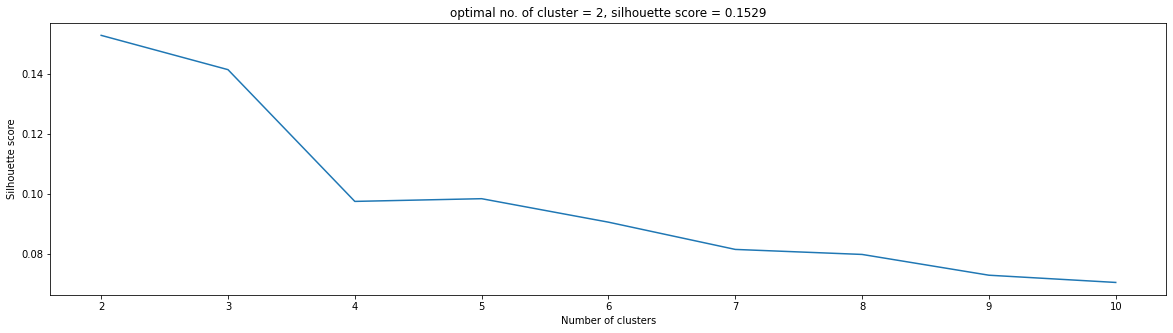

,AGE_P,FGA_P,FG_PCT_P,FG3A_P,FG3_PCT_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PTS_P,DD2_P,TD3_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,OFF_RATING_P,OREB_PCT_P,PACE_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,FGA_T,FG_PCT_T,FG3A_T,FG3_PCT_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PTS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,OFF_RATING_T,OREB_PCT_T,PACE_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,ERA_0,ERA_1
0,0.64,0.389408,0.546341,0.011236,0.000,0.164706,0.811,0.329670,0.258065,0.147929,0.297297,0.122449,0.111111,0.181818,0.611111,0.297483,0.019608,0.000000,0.134725,0.228395,0.139896,0.433243,0.244373,0.546341,0.134328,0.166667,0.705618,0.331429,0.357004,0.567362,0.320225,0.500000,0.433735,0.311688,0.610256,0.322034,0.080357,0.267442,0.139373,0.888,0.000,0.875278,0.988999,0.011001,0.883212,0.808376,0.000000,0.115974,0.239209,0.331671,0.238095,0.112,0.000,0.124722,0.238733,0.280269,0.169048,0.873016,0.633663,0.296000,0.565517,0.402516,0.487310,0.779817,0.370968,0.772358,0.32,0.644068,0.288136,0.142857,0.333333,0.770035,0.680162,0.675325,0.752,0.280488,0.268116,0.509202,0.770035,0.816667,0.332852,0.496774,0.703704,0.316176,0.259615,0.437500,0.956989,0.457317,0.868687,0.260377,0.319249,0.297101,0.225410,0.731884,0.729412,0.735385,0.532951,0.680162,0.728337,0.271663,0.726190,0.796089,0.302452,0.409091,0.319328,0.744681,0.147321,0.264615,0.467049,0.319838,0.31,0.142857,0.288136,0.186275,0.241611,0.156250,0.611940,0.391753,0.248588,0.204082,0.797468,0.490741,0.333333,0.282258,0.398058,0.38,0.741176,0.728329,0.475641
1,0.24,0.364486,0.665041,0.000000,0.000,0.452941,0.606,0.461538,0.270968,0.165680,0.554054,0.142857,0.027778,0.575758,0.452381,0.382151,0.000000,0.000000,0.161290,0.220165,0.081606,0.441417,0.250804,0.665041,0.134328,0.192982,0.689888,0.497143,0.369422,0.692600,0.398876,0.666667,0.301205,0.363636,0.551282,0.322034,0.294643,0.581395,0.418118,0.677,0.000,0.640312,1.000000,0.000000,0.788321,0.258883,0.000000,0.343545,0.402878,0.596010,0.593168,0.323,0.000,0.359688,0.085262,0.320628,0.173810,0.873016,0.633663,0.296000,0.565517,0.402516,0.487310,0.779817,0.370968,0.772358,0.32,0.644068,0.288136,0.142857,0.333333,0.770035,0.680162,0.675325,0.752,0.280488,0.268116,0.509202,0.770035,0.816667,0.332852,0.496774,0.703704,0.316176,0.259615,0.437500,0.956989,0.457317,0.868687,0.260377,0.319249,0.297101,0.225410,0.731884,0.729412,0.735385,0.532951,0.680162,0.728337,0.271663,0.726190,0.796089,0.302452,0.409091,0.319328,0.744681,0.147321,0.264615,0.467049,0.319838,0.31,0.142857,0.288136,0.186275,0.241611,0.156250,0.611940,0.391753,0.248588,0.204082,0.797468,0.490741,0.333333,0.282258,0.398058,0.38,0.741176,0.697057,0.425445
2,0.64,0.925234,0.556098,0.286517,0.347,0.605882,0.852,0.208791,0.296774,0.301775,0.283784,0.428571,0.097222,0.272727,0.126984,0.876430,0.058824,0.000000,0.347249,0.216049,0.294041,0.411444,0.273312,0.600000,0.854478,1.000000,0.838202,0.205714,0.298021,0.673624,0.800562,0.601449,0.349398,0.240260,0.571795,0.4

In [15]:
fit_seasonsimilarity = SeasonSimilarity(random_state=42, best_silh=True).fit(num_clean, plot_silh=True)
season_prepared = pd.DataFrame(fit_seasonsimilarity.transform(num_clean),
                               columns = fit_seasonsimilarity.get_feature_names_out())
season_prepared

### add to num_pipeline

In [16]:
# add to num_pipeline
num_pipeline.steps.append(
    ('season', SeasonSimilarity(random_state=42, n_clusters=2)) # choose 2 here instead of tuning as a hyperparameter
)

In [17]:
num_pipeline

Pipeline(steps=[('fixpf', FixPF(col_drop='PFD_P', col_replace='OPP_PF_T')),
                ('dropcols',
                 DropCols(cols_drop=['GP_P', 'W_P', 'L_P', 'W_PCT_P', 'PFD_P',
                                     'MIN_P', 'FGM_P', 'FG3M_P', 'FTM_P',
                                     'OPP_FGM_P', 'OPP_FG3M_P', 'OPP_FTM_P',
                                     'TM_TOV_PCT_P', 'REB_P', 'REB_PCT_P',
                                     'PLUS_MINUS_P', 'NET_RATING_P',
                                     'PACE_PER40_P', 'POSS_P', 'PIE_P', 'GP_T',
                                     'W_T', 'L_T', 'W_PCT_T', 'PFD_T', 'MIN_T',
                                     'FGM_T', 'FG3M_T', 'FTM_T', 'OPP_FGM_T', ...])),
                ('myminmaxscaler', MyMinMaxScaler()),
                ('season', SeasonSimilarity(n_clusters=2, random_state=42))])

### Alternative: agglomerative clustering

In [18]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram

# # create a custom transformer to cluster nba seasons into era
# class SeasonSimilarity2(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, compute_distances = True):
#     self.n_clusters = n_clusters
#     self.compute_distances = compute_distances
  
#   def fit(self, X, y = None, sample_weight = None):
#     # group by season to get league average
#     X_season = X.groupby("SEASON").mean().sort_index()
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X_season.sort_index().index.values
#     self.agg_cluster_ = AgglomerativeClustering(n_clusters=self.n_clusters, compute_distances=self.compute_distances)
#     self.agg_cluster_.fit(X_season)
#     return self
  
#   def transform(self, X):
#     X_season = X.groupby("SEASON").mean().sort_index()
#     X_cluster = pd.DataFrame(self.agg_cluster_.predict(X_season), index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
#     output = X[["SEASON"]].merge(X_cluster, how = "inner", on = "SEASON")
#     output.drop(columns = ["SEASON"], inplace = True)
#     output.index = X[["SEASON"]]
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

#   def plot_dendrogram(self, **kwargs):
#     model = self.agg_cluster_
#     def create_plot(model, **kwargs):
#       # Create linkage matrix and then plot the dendrogram

#       # create the counts of samples under each node
#       counts = np.zeros(model.children_.shape[0])
#       n_samples = len(model.labels_)
#       for i, merge in enumerate(model.children_):
#           current_count = 0
#           for child_idx in merge:
#               if child_idx < n_samples:
#                   current_count += 1  # leaf node
#               else:
#                   current_count += counts[child_idx - n_samples]
#           counts[i] = current_count

#       linkage_matrix = np.column_stack(
#           [model.children_, model.distances_, counts]
#       )

#       # Plot the corresponding dendrogram
#       dendrogram(linkage_matrix, **kwargs)

#     create_plot(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     locs, labels = plt.xticks() 
#     plt.xticks(locs, [season['SEASON'].unique().to_list()[int(x.get_text())] for x in labels])
#     plt.show()

In [19]:
# agg_cluster = SeasonSimilarity2(n_clusters = 3, compute_distances=True).fit(season)
# agg_cluster.plot_dendrogram()

## (optional) Dimensionality reduction
- advantage
  - PCA can solve the axis orientation issue with decision tree
- disadvantage
  - information loss
  - harder to maintain pipeline as new data comes in
    - assume the current dataset is a random sampling of the underlying population, the PCA components should be stable
- considerations
  - let's not use PCA to allow interpretation of our feature
  - if we need to use decision tree, we can still use random forests or other ensemble methods on top of it
  - but random forest still assign high feature importance to highly correlated features (e.g. W_PCT, W, L)

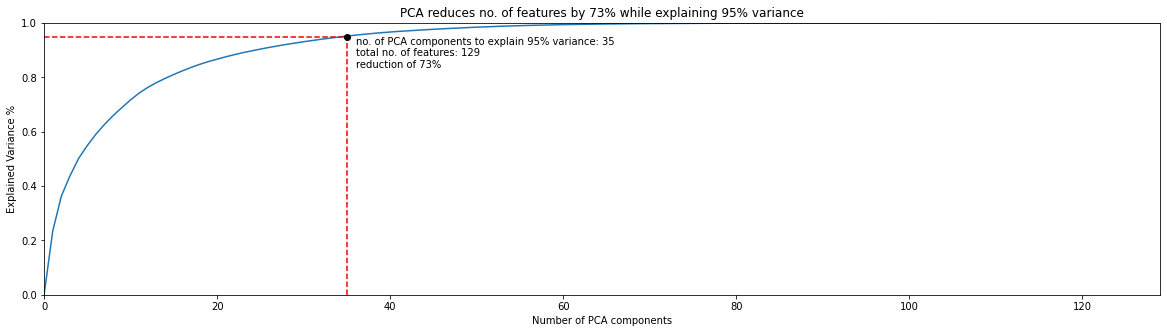

In [20]:
pca = PCA().fit(season_prepared)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
# aim for 95% variance explained
target = np.argmax(pca_cumsum >= 0.95) + 1 # python starts counting at 0
plt.plot([*range(0,len(pca_cumsum)+1)], [0, *pca_cumsum])
plt.xlim(0,len(pca_cumsum))
plt.ylim(0,1)
plt.xlabel("Number of PCA components")
plt.ylabel("Explained Variance %")
plt.plot([target, target], [0, 0.95], 'r--')
plt.plot([0, target], [0.95, 0.95], 'r--')
plt.plot(target, 0.95, 'ko')
plt.annotate(f"no. of PCA components to explain 95% variance: {target}\n" + 
             f"total no. of features: {pca.n_features_in_}\n" + 
             f"reduction of {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%}", 
             [target+1, 0.95],
             ha = 'left',
             va = 'top')
plt.title(f"PCA reduces no. of features by {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%} while explaining 95% variance")
plt.show()

In [21]:
# don't add to data_preparation pipeline
# while PCA can help reduce no. of features significantly, reduce training time and avoid axis orientation issues in decision tree, 
# I want to keep features interpretable given the dataset is not too large

# data_preparation.steps.append(
#     ("pca", PCA(n_components=0.95))
# )

In [22]:
# print(f"target no. of features to explain 95% variance = {data_preparation.fit_transform(season).shape[1]}")

## Feature selection with lasso penalty
- use lasso penalty with logistic regression to select useful features
- threshold = hyperparameter to tune

In [23]:
selector = SelectFromModel(
    LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
    threshold=None # hyperparameter to tune
    ).fit(season_prepared, season_label.reshape(-1,))

In [24]:
# hyperparameter to tune
selector.threshold_

1e-05

In [25]:
# original training set
season.shape

(5701, 177)

In [26]:
# reduced no. of features
selector.transform(season_prepared).shape

(5701, 41)

In [27]:
# columns dropped
sorted(season_prepared.columns[~selector.get_support()])

['AST_P',
 'AST_PCT_P',
 'AST_PCT_T',
 'AST_RATIO_P',
 'AST_RATIO_T',
 'AST_T',
 'AST_TO_P',
 'AST_TO_T',
 'BLKA_P',
 'BLK_P',
 'BLK_T',
 'DREB_P',
 'DREB_PCT_P',
 'DREB_PCT_T',
 'EFG_PCT_P',
 'ERA_1',
 'FG3A_P',
 'FG3_PCT_P',
 'FGA_P',
 'FGA_PG_P',
 'FGA_T',
 'FGM_PG_P',
 'FG_PCT_P',
 'FTA_P',
 'FTA_RATE_T',
 'FTA_T',
 'FT_PCT_P',
 'OFF_RATING_P',
 'OPP_BLKA_T',
 'OPP_EFG_PCT_T',
 'OPP_FG3A_T',
 'OPP_FG3_PCT_T',
 'OPP_FGA_T',
 'OPP_FTA_RATE_T',
 'OPP_OREB_PCT_T',
 'OPP_OREB_T',
 'OPP_PFD_T',
 'OPP_PF_T',
 'OPP_PTS_FB_P',
 'OPP_PTS_OFF_TOV_P',
 'OPP_PTS_OFF_TOV_T',
 'OPP_PTS_PAINT_P',
 'OPP_PTS_PAINT_T',
 'OPP_PTS_T',
 'OPP_STL_T',
 'OREB_P',
 'OREB_PCT_P',
 'OREB_PCT_T',
 'OREB_T',
 'PACE_P',
 'PCT_AST_2PM_P',
 'PCT_AST_2PM_T',
 'PCT_AST_FGM_P',
 'PCT_AST_FGM_T',
 'PCT_BLK_P',
 'PCT_DREB_P',
 'PCT_FGA_2PT_P',
 'PCT_FGA_2PT_T',
 'PCT_FGA_3PT_P',
 'PCT_FGA_3PT_T',
 'PCT_PTS_2PT_MR_T',
 'PCT_PTS_2PT_P',
 'PCT_PTS_2PT_T',
 'PCT_PTS_3PT_T',
 'PCT_PTS_FB_P',
 'PCT_PTS_FT_P',
 'PCT_PTS_OFF_T

In [28]:
# columns retained
sorted(selector.get_feature_names_out())

['AGE_P',
 'BLKA_T',
 'DD2_P',
 'DEF_RATING_P',
 'DEF_RATING_T',
 'DREB_T',
 'EFG_PCT_T',
 'ERA_0',
 'FG3A_T',
 'FG3_PCT_T',
 'FG_PCT_T',
 'FT_PCT_T',
 'OFF_RATING_T',
 'OPP_AST_T',
 'OPP_BLK_T',
 'OPP_DREB_T',
 'OPP_FG_PCT_T',
 'OPP_FTA_T',
 'OPP_FT_PCT_T',
 'OPP_PTS_2ND_CHANCE_P',
 'OPP_PTS_2ND_CHANCE_T',
 'OPP_PTS_FB_T',
 'OPP_REB_T',
 'OPP_TOV_PCT_T',
 'OPP_TOV_T',
 'PACE_T',
 'PCT_AST_3PM_P',
 'PCT_AST_3PM_T',
 'PCT_PTS_2PT_MR_P',
 'PCT_PTS_3PT_P',
 'PCT_PTS_FB_T',
 'PCT_PTS_FT_T',
 'PCT_PTS_OFF_TOV_P',
 'PCT_UAST_2PM_P',
 'PCT_UAST_3PM_T',
 'PF_P',
 'PTS_2ND_CHANCE_T',
 'PTS_OFF_TOV_T',
 'PTS_PAINT_P',
 'PTS_PAINT_T',
 'PTS_T']

## Final pipeline = data_preparation



In [29]:
num_pipeline

Pipeline(steps=[('fixpf', FixPF(col_drop='PFD_P', col_replace='OPP_PF_T')),
                ('dropcols',
                 DropCols(cols_drop=['GP_P', 'W_P', 'L_P', 'W_PCT_P', 'PFD_P',
                                     'MIN_P', 'FGM_P', 'FG3M_P', 'FTM_P',
                                     'OPP_FGM_P', 'OPP_FG3M_P', 'OPP_FTM_P',
                                     'TM_TOV_PCT_P', 'REB_P', 'REB_PCT_P',
                                     'PLUS_MINUS_P', 'NET_RATING_P',
                                     'PACE_PER40_P', 'POSS_P', 'PIE_P', 'GP_T',
                                     'W_T', 'L_T', 'W_PCT_T', 'PFD_T', 'MIN_T',
                                     'FGM_T', 'FG3M_T', 'FTM_T', 'OPP_FGM_T', ...])),
                ('myminmaxscaler', MyMinMaxScaler()),
                ('season', SeasonSimilarity(n_clusters=2, random_state=42))])

In [30]:
data_preparation = make_pipeline(
    
    # data cleaning
    ColumnTransformer([
        # fixing columns / drop columns / quantile transform / clustering numeric columns
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
      ], 
      # drop remaining string columns such as TEAM_ID
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    ),

    # feature selection
    SelectFromModel(
      LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
      threshold=None # hyperparameter to tune
    )
)

In [31]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fixpf',
                                                                   FixPF(col_drop='PFD_P',
                                                                         col_replace='OPP_PF_T')),
                                                                  ('dropcols',
                                                                   DropCols(cols_drop=['GP_P',
                                                                                       'W_P',
                                                                                       'L_P',
                                                                                       'W_PCT_P',
                                                                                       'PFD_P',
                                                                                   

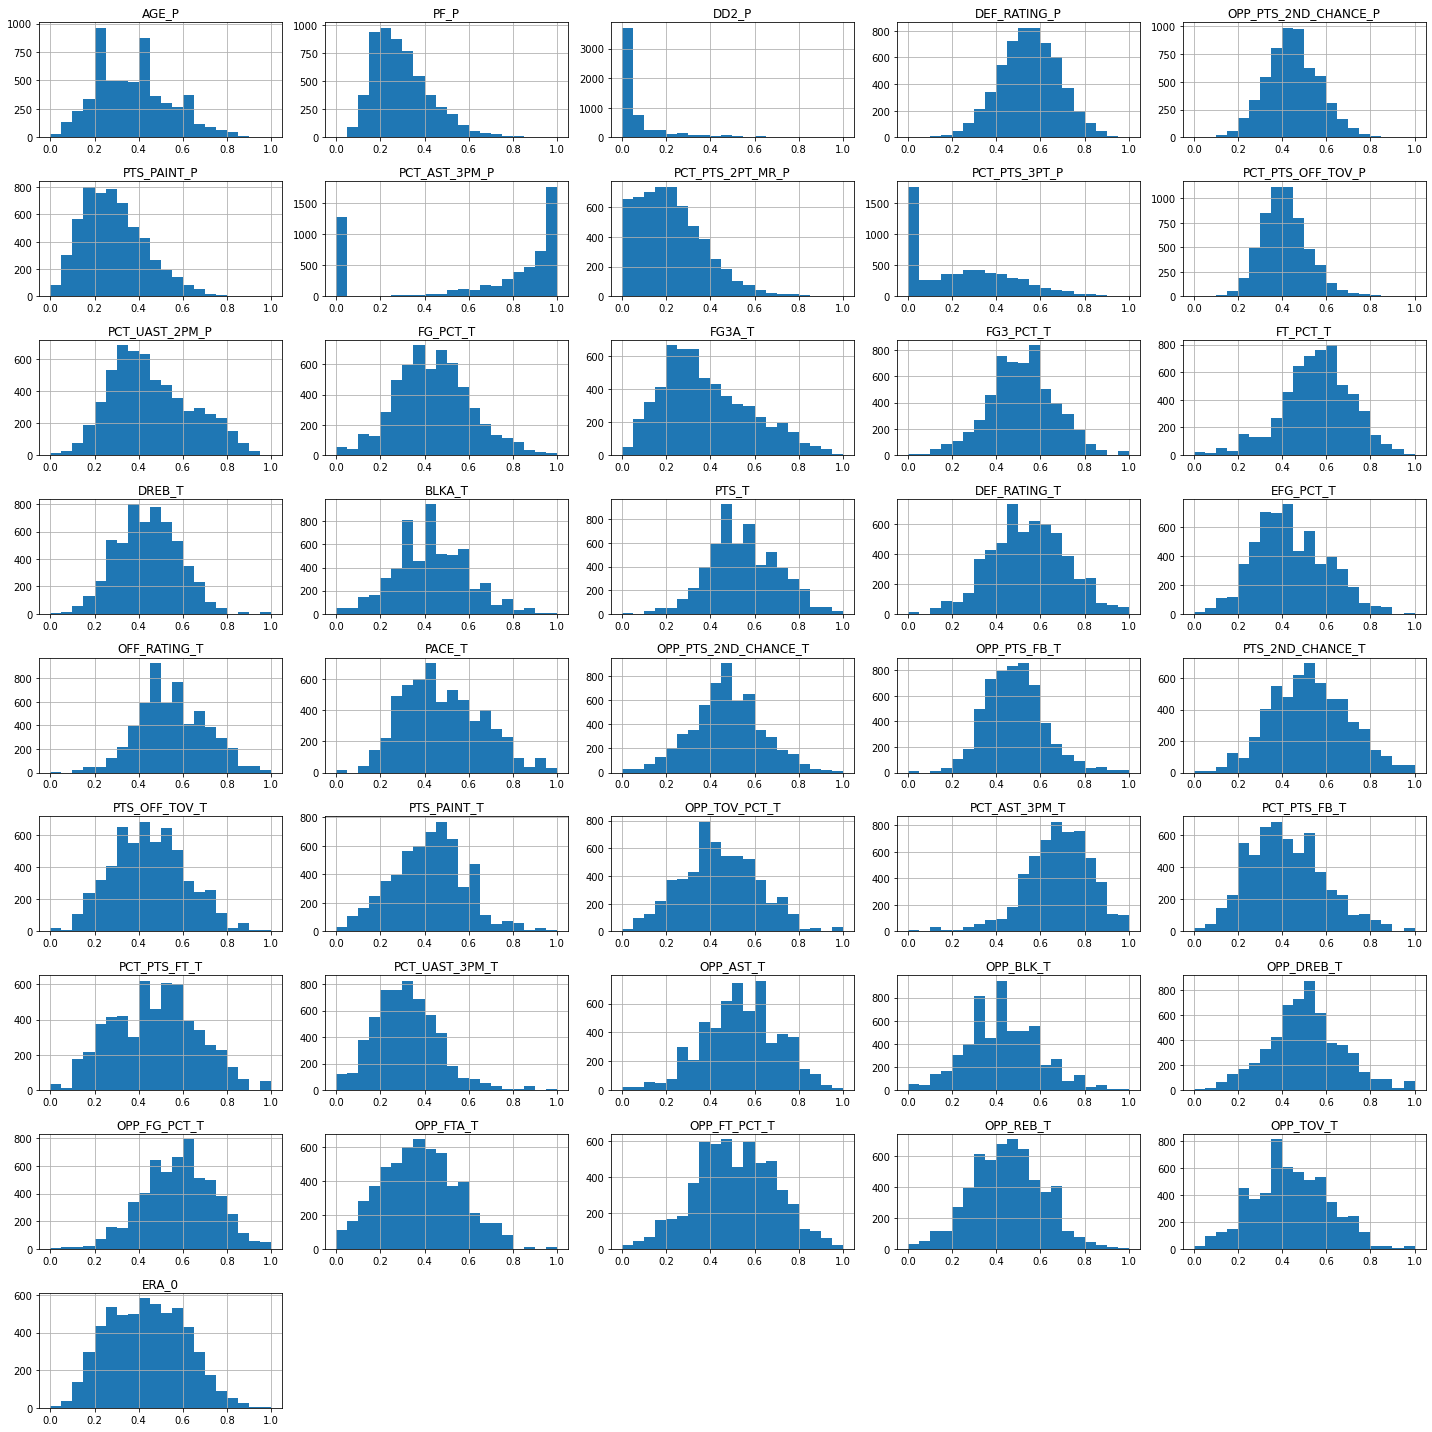

In [32]:
# plot distributions of each feature in X_train
plot_df = pd.DataFrame(data_preparation.fit_transform(season, season_label), 
                       columns = data_preparation.get_feature_names_out()).astype(float)
plot_df.hist(bins = 20, layout = (int(plot_df.shape[1] / 5) + 1, 5), figsize = (20,20))
plt.title("Distribution of each feature after cleaning")
plt.tight_layout()

# Shortlist promising models
- missing 
  - analyze most significant variables for each algorithm
  - analyze the type of errors the models make
    - what data would a human to use avoid these errors
  - perform a quick round of feature engineering and selection
  - shortlist models making different types of error

In [47]:
# create a list of models using standard hyperparameters to compare performance
dict_clf = {
    # 1) need predict_proba() for all classifiers such that we can use some ensemble methods later
    # 2) class imbalance in data
      # current method: rebalance class weight
      # alternative: sampling methods, e.g. oversampling, undersampling, SMOTE, ADA
      # medium article: 

    # "knn": KNeighborsClassifier(),
    "sgd": SGDClassifier(random_state=42, loss='log', penalty='elasticnet', class_weight='balanced'), # SGD solver for logistic regression
    # "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4, class_weight='balanced'),
    "svc": SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced'), # SVC instead of LinearSVC for predict_proba()
    "svc_poly": SVC(kernel='poly', random_state=42, probability=True, class_weight='balanced'), # probability=True for predict_proba()
    "svc_rbf": SVC(kernel='rbf', random_state=42, probability=True, class_weight='balanced'), # probability=True for predict_proba()
    "tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "forest": RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
    # "gb": GradientBoostingClassifier(random_state=42),
    # "ada": AdaBoostClassifier(random_state=42),
    "xgb": XGBClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1)),
    "xgbrf": XGBRFClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1))
}

In [48]:
list_clf = []
AP_CVs = []
AP_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AP
for key, item in tqdm(dict_clf.items()):
  print(key)
  # add estimator after data_preparation pipeline
  clf = Pipeline(
      data_preparation.steps + [(key, item)]
      ).fit(season, season_label)
  
  # cross validation score
  AP_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'average_precision')
  # cross validation predict 
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(season_label, y_scores)

  list_clf.append(key)
  AP_CVs.append(AP_CV)
  AP_train.append(average_precision_score(season_label, clf.predict_proba(season)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

  0%|          | 0/8 [00:00<?, ?it/s]

sgd


 12%|█▎        | 1/8 [02:21<16:28, 141.21s/it]

svc


 25%|██▌       | 2/8 [05:56<18:28, 184.78s/it]

svc_poly


 38%|███▊      | 3/8 [09:07<15:37, 187.44s/it]

svc_rbf


 50%|█████     | 4/8 [12:30<12:54, 193.68s/it]

tree


 62%|██████▎   | 5/8 [14:48<08:40, 173.50s/it]

forest


 75%|███████▌  | 6/8 [17:25<05:35, 168.00s/it]

xgb


 88%|████████▊ | 7/8 [20:12<02:47, 167.62s/it]

xgbrf


100%|██████████| 8/8 [22:49<00:00, 171.14s/it]


In [49]:
# sort the models by AP but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_AP = [np.mean(AP) for AP in AP_CVs]
sd_AP = [np.std(AP) for AP in AP_CVs]
print("Models sorted by cross validation AP score")
for mean, sd, clf_name in sorted(zip(mean_AP, sd_AP, list_clf), reverse = True):
  print(f"CV AP: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AP score
CV AP: AVG 0.7975 / SD 0.1853 / forest
CV AP: AVG 0.7113 / SD 0.1895 / xgb
CV AP: AVG 0.4376 / SD 0.2358 / svc_rbf
CV AP: AVG 0.4371 / SD 0.1478 / xgbrf
CV AP: AVG 0.4099 / SD 0.2702 / svc_poly
CV AP: AVG 0.3613 / SD 0.2940 / svc
CV AP: AVG 0.3477 / SD 0.2371 / sgd
CV AP: AVG 0.3097 / SD 0.1712 / tree


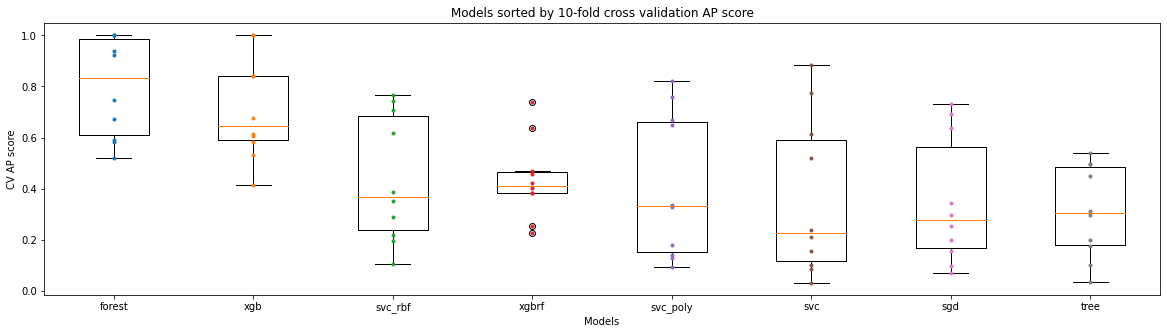

In [50]:
# sort the models and plot the spread of CV AP scores
mean_AP = [np.mean(AP) for AP in AP_CVs]
sorted_AP_CV = [i for _, i in [(mean_AP[i], AP_CVs[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_clf = [i for _, i in [(mean_AP[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_AP_train = [i for _, i in [(mean_AP[i], AP_train[i]) for i in np.argsort(mean_AP)[::-1]]]
plt.boxplot(sorted_AP_CV, labels=sorted_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_AP_CV):
  plt.plot([i+1]*len(AP), AP, ".")
# plt.plot([*range(1,len(sorted_AP_CV)+1,1)], sorted_AP_train, "ks")
plt.title(f"Models sorted by {cv}-fold cross validation AP score")
plt.xlabel("Models")
plt.ylabel("CV AP score")
plt.show()

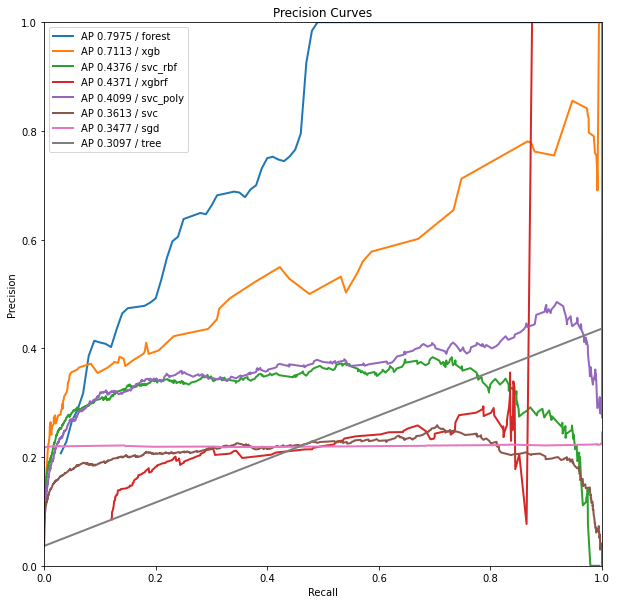

In [51]:
figure(figsize=(10, 10))
for AP, precision, recall, thresholds, clf_name in [(mean_AP[i], list_precision[i], list_recall[i], list_thresholds[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]:
  # if clf_name == 'tree':
  plt.plot(thresholds, precision[:-1], linewidth = 2, label = f"AP {AP:0.4f} / {clf_name}")
    # plt.plot(recall, precision, linewidth = 2, label = f"AP {AP:0.4f} / {clf_name}")
# plt.plot([0,1], [0,1], 'k:', label = "AP 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Precision Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [45]:
# print top models to tune
top = 5
for name in sorted_clf[:top]:
  print(name, dict_clf[name])

NameError: ignored

In [53]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
# expon = False
# count = 1
# for i in range(1,10**2,10**1):
#   if expon:
#     count = count * i/10**20 / (i/10**22)
#     i = count
#   else:
#     i = i/10**2
#   full_pipeline = make_pipeline(
#       data_preparation,
#       AdaBoostClassifier(random_state=42, learning_rate=i)
#   )

#   full_pipeline.fit(season, season_label)
#   cv_score = cross_val_score(full_pipeline, season, season_label, cv = 5, scoring='roc_auc')
#   auc_train = roc_auc_score(season_label, full_pipeline.predict_proba(season)[:,1])
#   print(f"choice {i}, CV AUC {cv_score}")
#   print(f"mean AUC {np.mean(cv_score):0.4f}, std AUC {np.std(cv_score):0.4f} / train AUC {auc_train:0.4f}")
#   # print(full_pipeline.get_params().keys())
#   # plt.hist([np.log2(x) for x in loguniform(a=2**-2, b=2**2).rvs(size=10**6)])

## Set up hyperparameter grid

In [47]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "xgb": XGBClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1)),
    # "ada": AdaBoostClassifier(random_state=42),
    # "gb": GradientBoostingClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
    "tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "xgbrf": XGBRFClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1)),
    # "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4, class_weight='balanced'),
    # "svc": SVC(kernel='linear', probability=True, max_iter=10**5, random_state=42),
    # "svc_poly": SVC(kernel='poly', probability=True, random_state=42, class_weight='balanced'),
    # "svc_rbf": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    "sgd": SGDClassifier(random_state=42, penalty='elasticnet', loss='log', class_weight='balanced')
    
}

param_grids = {
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__gamma": uniform(loc = 0, scale = 10),
        "xgb__reg_alpha": uniform(loc = 0, scale = 10),
        "xgb__reg_gamma": uniform(loc = 0, scale = 10),
        "xgb__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgb__max_depth": randint(low = 1, high = 5),
        "xgb__min_child_weight": randint(low = 1, high = 30),
    },

    "xgbrf": {
        "xgbrf__gamma": uniform(loc = 0, scale = 10),
        "xgbrf__reg_alpha": uniform(loc = 0, scale = 10),
        "xgbrf__reg_gamma": uniform(loc = 0, scale = 10),
        "xgbrf__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgbrf__max_depth": randint(low = 1, high = 5),
        "xgbrf__min_child_weight": randint(low = 1, high = 30),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    "forest": {
        "forest__max_depth": randint(low = 3, high = 5),
        "forest__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "forest__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    "tree": {
        "tree__criterion": ['gini', 'entropy'],
        "tree__max_depth": randint(low = 3, high = 5),
        "tree__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "tree__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier
    "ada": {
        "ada__learning_rate": loguniform(a = 10**-2, b = 10**0),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboost#sklearn.ensemble.GradientBoostingClassifier
    "gb": {
        "gb__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        "gb__max_depth": randint(low = 1, high = 5),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "logistic": {
        "logistic__C": loguniform(a = 10**-3, b = 10**-1),
        "logistic__l1_ratio": uniform(loc = 0, scale = 1),
    },

     # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc_poly": {
        "svc_poly__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc": {
        "svc__C": loguniform(a = 10**-20, b = 10**1)
    },


    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc_rbf": {
        "svc_rbf__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
    "sgd": {
        "sgd__l1_ratio": uniform(loc = 0, scale = 1),
        "sgd__alpha": loguniform(a = 10**-3, b = 10**-1),
        "sgd__learning_rate": ['optimal', 'adaptive'],
        "sgd__eta0": loguniform(a = 10**-3, b = 10**-1)
    }
    
}

In [48]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [49]:
random_clfs = []
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for clf_name, clf in tqdm(shortlisted_clfs.items()):

  full_pipeline = Pipeline(
      data_preparation.steps + [(clf_name, clf)]
      )

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  # tune C for inverse of regularization strength in lasso penalty for feature selection in data_prepartion pipeline
  param_grid["selectfrommodel__estimator__C"] = loguniform(a = 10**0, b = 10**1)
  
  print(param_grid)

  random_search = RandomizedSearchCV(full_pipeline, 
                                    param_grid, 
                                    cv = 10, 
                                    n_iter = 100, 
                                    scoring = "average_precision",
                                    random_state = 42,
                                    n_jobs = -1,
                                    error_score = 'raise')

  random_search.fit(season, season_label)
  random_clfs.append(random_search)

  print(f"\nbest_score: {random_search.best_score_}")
  print(f"best_params: {random_search.best_params_}")
  # print(pd.DataFrame(random_search.cv_results_))

  print(f'{clf_name} class balanced AP player + team {random_search.best_estimator_.steps[-1][0]} dumped {current_time}')
  dump(random_search, f'{clf_name}_tuned_class_balanced_AP_playerplusteam_{current_time}.joblib') 

  0%|          | 0/5 [00:00<?, ?it/s]

xgb
XGBClassifier(random_state=42, scale_pos_weight=26.408653846153847)
{'xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa1b5e7c10>, 'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa1b5e74d0>, 'xgb__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa170e4150>, 'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa12d7f410>, 'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa12d7ff50>, 'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa12ca3750>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa10ac2e10>}


 20%|██        | 1/5 [1:10:08<4:40:33, 4208.40s/it]


best_score: 0.7359470913084637
best_params: {'selectfrommodel__estimator__C': 3.3957411954448697, 'xgb__gamma': 4.477831645730916, 'xgb__learning_rate': 0.562893089071328, 'xgb__max_depth': 3, 'xgb__min_child_weight': 4, 'xgb__reg_alpha': 0.8085332633271525, 'xgb__reg_gamma': 3.6965445606140444}
xgb class balanced AP player + team xgb dumped 20220918_175657
forest
RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
{'forest__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa167ef190>, 'forest__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa167ef3d0>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa17314850>}


 40%|████      | 2/5 [2:15:44<3:22:24, 4048.26s/it]


best_score: 0.6367381462763698
best_params: {'forest__max_depth': 4, 'forest__min_samples_split': 0.1127095633720476, 'selectfrommodel__estimator__C': 1.2820100418916898}
forest class balanced AP player + team forest dumped 20220918_175657
tree
DecisionTreeClassifier(class_weight='balanced', random_state=42)
{'tree__criterion': ['gini', 'entropy'], 'tree__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16b0f4d0>, 'tree__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16b0f5d0>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16b0f510>}


 60%|██████    | 3/5 [3:10:22<2:03:13, 3696.56s/it]


best_score: 0.25511595235417317
best_params: {'selectfrommodel__estimator__C': 7.950932329069353, 'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 0.2695148955243504}
tree class balanced AP player + team tree dumped 20220918_175657
xgbrf
XGBRFClassifier(random_state=42, scale_pos_weight=26.408653846153847)
{'xgbrf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16e56710>, 'xgbrf__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16e56410>, 'xgbrf__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16e56510>, 'xgbrf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa19db8510>, 'xgbrf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa19db89d0>, 'xgbrf__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa12d286d0>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa16e564d0>}

 80%|████████  | 4/5 [4:17:19<1:03:43, 3823.22s/it]


best_score: 0.5989911848435627
best_params: {'selectfrommodel__estimator__C': 1.1872731425335898, 'xgbrf__gamma': 9.868869366005173, 'xgbrf__learning_rate': 0.7822447692966574, 'xgbrf__max_depth': 4, 'xgbrf__min_child_weight': 8, 'xgbrf__reg_alpha': 0.05522117123602399, 'xgbrf__reg_gamma': 8.154614284548341}
xgbrf class balanced AP player + team xgbrf dumped 20220918_175657
sgd
SGDClassifier(class_weight='balanced', loss='log', penalty='elasticnet',
              random_state=42)
{'sgd__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa10cfbf50>, 'sgd__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa10cfb910>, 'sgd__learning_rate': ['optimal', 'adaptive'], 'sgd__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa10cfbe90>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffa10cfb310>}


100%|██████████| 5/5 [5:13:08<00:00, 3757.75s/it]


best_score: 0.4760048536077498
best_params: {'selectfrommodel__estimator__C': 1.1056146170228396, 'sgd__alpha': 0.09752164572338576, 'sgd__eta0': 0.008707410675803566, 'sgd__l1_ratio': 0.2795603417967586, 'sgd__learning_rate': 'adaptive'}
sgd class balanced AP player + team sgd dumped 20220918_175657


## Check CV result after hyperparameter tuning

In [33]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [34]:
tuned_models = {}
time_list = []
time_diff = []
match_pattern = '_tuned_class_balanced_AP_playerplusteam_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "SMOTE AP loaded")

xgb SMOTE AP loaded
forest SMOTE AP loaded
tree SMOTE AP loaded
xgbrf SMOTE AP loaded
sgd SMOTE AP loaded


### Average precision

In [35]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  # tuned_AP.append(cross_val_score(model.best_estimator_, season, season_label, cv = 10, scoring='average_precision'))
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [36]:
from sklearn.metrics import average_precision_score
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(auc) for auc in tuned_AP]
mean_train_AP = [average_precision_score(season_label, model.best_estimator_.predict_proba(season)[:,1]) for _, model in tuned_models.items()]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]
sorted_train_AP = [i for _, i in sorted(zip(mean_tuned_AP, mean_train_AP), reverse = True)]

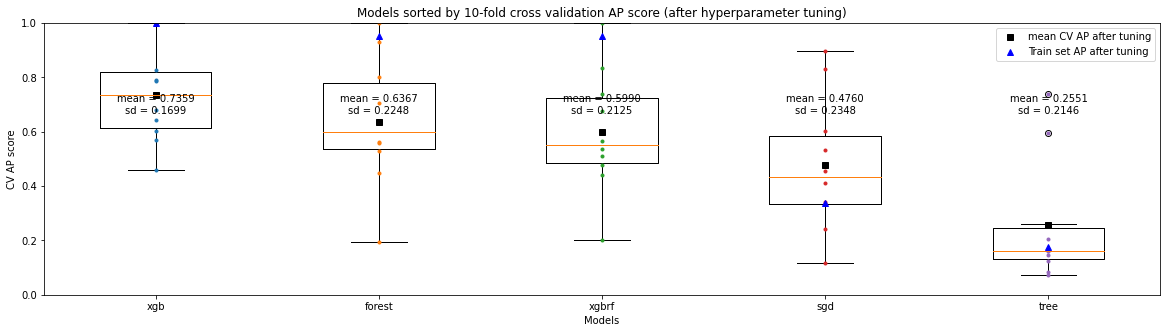

In [37]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted_train_AP, 
         "b^", label = 'Train set AP after tuning')
# plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], [mean_AP[list_clf.index(x)] for x in sorted_tuned_clf], 
#          "k^", label = 'mean CV AP before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AP score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AP score")
plt.show()

### AUROC

In [38]:
list_clf = []
auc_CVs = []
auc_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AUC
for key, item in tqdm(tuned_models.items()):
  clf = item.best_estimator_.fit(season, season_label)
  auc_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'roc_auc')
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(season_label, y_scores)

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  auc_train.append(roc_auc_score(season_label, clf.predict_proba(season)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

100%|██████████| 5/5 [07:24<00:00, 88.85s/it]


In [56]:
sorted_tuned_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_CVs), reverse = True)]
sorted_train_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_train), reverse = True)]

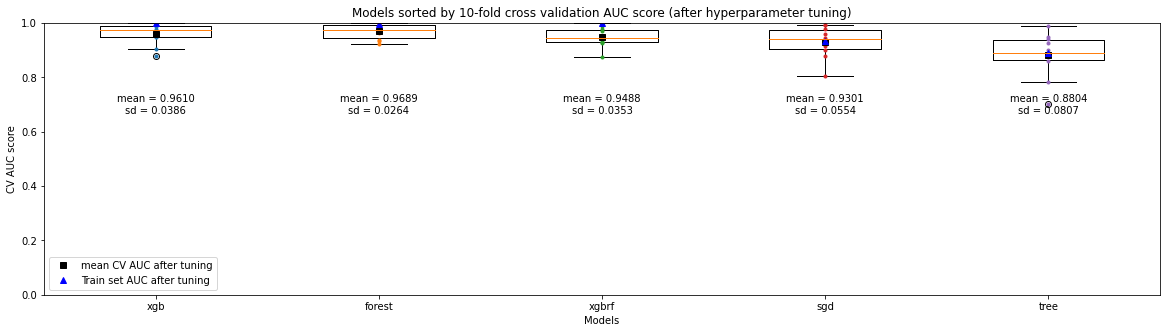

In [57]:
plt.boxplot(sorted_tuned_AUC, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_tuned_AUC):
  plt.plot([i+1]*len(AUC), AUC, ".")
  plt.annotate(f"mean = {np.mean(AUC):0.4f}\nsd = {np.std(AUC):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [np.mean(x) for x in sorted_tuned_AUC], 
         "ks", label = 'mean CV AUC after tuning')
plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], sorted_train_AUC, 
         "b^", label = 'Train set AUC after tuning')
# plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [mean_AUC[list_clf.index(x)] for x in list_clf], 
#          "k^", label = 'mean CV AUC before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AUC score")
plt.show()

### coefficients and precision-recall curve

In [43]:
best_model = tuned_models['xgb'].best_estimator_

Number of features after fitting estimator with regularization: 
26
features = ['PTS_T', 'OPP_AST_T', 'OPP_PTS_OFF_TOV_T', 'DEF_RATING_T', 'PCT_AST_2PM_T', 'OPP_DREB_T', 'FT_PCT_T', 'OPP_FTA_T', 'OPP_PTS_2ND_CHANCE_T', 'FG_PCT_T', 'DREB_T', 'BLK_T', 'EFG_PCT_T', 'PCT_AST_3PM_T', 'OPP_PF_T', 'OPP_TOV_PCT_T', 'OPP_FG3_PCT_T', 'PTS_PAINT_T', 'PTS_OFF_TOV_T', 'OREB_PCT_T', 'OPP_STL_T', 'BLKA_T', 'PACE_T', 'AST_PCT_T', 'OPP_REB_T', 'OPP_FT_PCT_T']
coefficient = [0.1985, 0.1393, 0.0873, 0.0855, 0.0847, 0.0453, 0.0371, 0.0334, 0.0327, 0.0284, 0.026, 0.0259, 0.0227, 0.0183, 0.0173, 0.0171, 0.0171, 0.0154, 0.0152, 0.0149, 0.013, 0.0101, 0.0063, 0.0057, 0.0017, 0.0012]


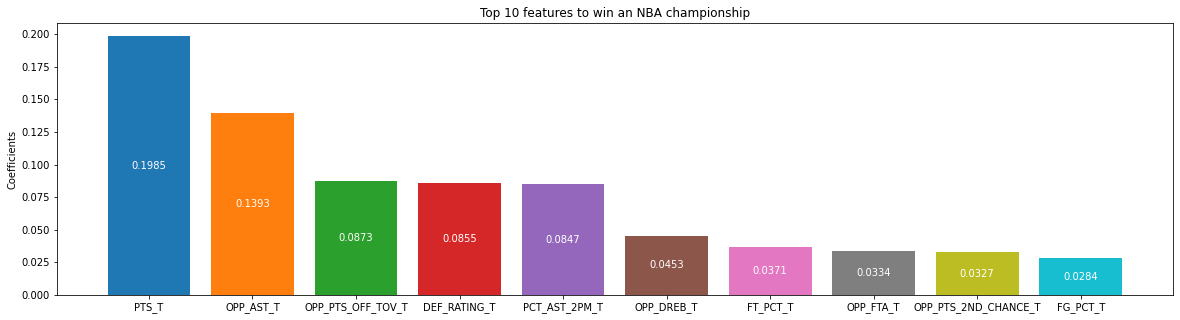

In [44]:
# non-zero (signficant) features after regularization in fitting estimator
features_out = best_model[:-1].get_feature_names_out() 
coef = best_model.steps[-1][1].feature_importances_
print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

abs_coef = np.abs(coef)
fig, ax = plt.subplots(1,1)
top_n = 10
for i, (_, coef, name) in enumerate(sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]):
  ax.bar(name, coef)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.title(f"Top {top_n} features to win an NBA championship")
plt.ylabel("Coefficients")
plt.show()

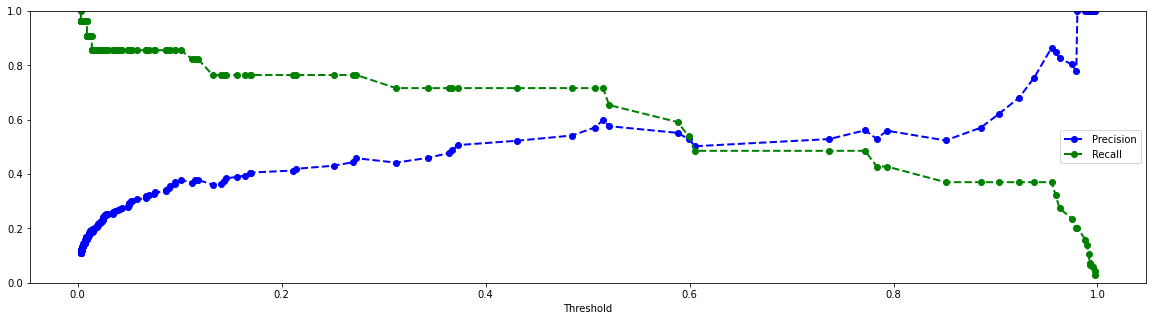

In [45]:
idx = list_clf.index(best_model.steps[-1][0])
precisions = list_precision[idx]
recalls = list_recall[idx]
thresholds = list_thresholds[idx]
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
# plt.axhline(0.9, c='k')
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.legend()
plt.show()

# Ensemble methods
- Combining tuned models with ensemble learning
- Not to use due to loss in interpretability

In [61]:
# get performance from adaboost and bagging ensemble methods on each tuned model
single_clf_ensemble_models = {
    "Adaboost": AdaBoostClassifier(random_state = 42),
    "Bagging": BaggingClassifier(random_state = 42, n_estimators=50)
}

for ensemble_key, ensemble_model in single_clf_ensemble_models.items():
  for model in sorted_tuned_clf:
    ensemble_model.base_estimator = tuned_models[model].best_estimator_.steps[-1][1]
    ensemble_pipeline = Pipeline(data_preparation.steps + [(ensemble_key, ensemble_model)])

    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'average_precision')
    print(f"mean AP = {np.mean(cv_score):0.4f}, std AP = {np.std(cv_score):0.4f}, {ensemble_key} {model}")

mean AP = 0.0365, std AP = 0.0007, Adaboost xgb
mean AP = 0.7256, std AP = 0.2117, Adaboost forest
mean AP = 0.0365, std AP = 0.0007, Adaboost xgbrf
mean AP = 0.0365, std AP = 0.0007, Adaboost sgd
mean AP = 0.7579, std AP = 0.1545, Adaboost tree
mean AP = 0.7811, std AP = 0.1855, Bagging xgb
mean AP = 0.5460, std AP = 0.2080, Bagging forest
mean AP = 0.6141, std AP = 0.2031, Bagging xgbrf
mean AP = 0.4499, std AP = 0.2091, Bagging sgd
mean AP = 0.2855, std AP = 0.2164, Bagging tree


In [ ]:
# get performance from voting and stacking ensemble methods on an increasing basket of tuned models
multiple_clf_ensemble_models = {
    "Voting": VotingClassifier(voting = 'soft', estimators = []),
    "Stacking": StackingClassifier(cv = 10, final_estimator=RandomForestClassifier(random_state=43), estimators = [])
}

for ensemble_key, ensemble_model in multiple_clf_ensemble_models.items():
  for i in range(1,len(tuned_models)):
    ensemble_model.estimators = [(model, tuned_models[model].best_estimator_.steps[-1][1]) for model in sorted_tuned_clf[:(i+1)]]
    ensemble_pipeline = Pipeline(data_preparation.steps + [(ensemble_key, ensemble_model)])

    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'average_precision')
    print(f"mean AP = {np.mean(cv_score):0.4f}, std AP = {np.std(cv_score):0.4f}, {ensemble_key} {[model for model in sorted_tuned_clf[:(i+1)]]}")

mean AP = 0.7958, std AP = 0.1773, Voting ['xgb', 'forest']
mean AP = 0.7696, std AP = 0.1970, Voting ['xgb', 'forest', 'xgbrf']
mean AP = 0.7718, std AP = 0.1949, Voting ['xgb', 'forest', 'xgbrf', 'sgd']
mean AP = 0.7770, std AP = 0.1894, Voting ['xgb', 'forest', 'xgbrf', 'sgd', 'tree']


# Issue with best_estimator_ in SearchCV
sklearn returns best_estimator_ at best_index_ = highest mean_test_score 
- but if there is a tie based on mean_test_score, sklearn does not return the one with the lowest std_test_score
- https://github.com/scikit-learn/scikit-learn/blob/db8d67c6a10ef37bf58088e414bbe8a7f7160c60/sklearn/model_selection/_search.py#L1260